# LATW Challenge Problem: Mini global fit

In this challenge problem, you will combine what you have learned from the tutorials to build a miniature global fit pipeline. We will combine 1 MBHB with ~8 Galactic binaries. The Galactic binaries will be split in two groups with the groups separated in frequency so they are non-interacting. The goal is to fit for the MBHB and for the GBs while characterizing the uncertainty in the GB model count and parameters. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

## Generate the data

In [2]:
# waveform setup
from bbhx.waveformbuild import BBHWaveformFD
from lisatools.sensitivity import get_sensitivity, AE1SensitivityMatrix
from gbgpu.gbgpu import GBGPU
gb = GBGPU()
tdi_wave_gen = BBHWaveformFD()

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


### MBHB injection parameters and waveform 

In [3]:
# mbh injection parameters
m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024

# setup data holders
Tobs = YRSID_SI / 4  # 3 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)
df = freqs[1] - freqs[0]
AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs
)

### GBs parameters and waveforms

In [4]:
injection_binaries = np.asarray([
    [8.232131e-22, 0.0040004234, 1.5e-17, 0.0, 1.34248932, 3.0121342, 0.8923484, 0.034323, 1.023234],
    [7.823497204e-22, 0.00400087123489, 0.1e-17, 0.0, 3.47234293, 2.787263432, 1.2349823, 3.093492342, 0.9323423],
    [9.234809e-22, 0.004000923048231, 0.9e-17, 0.0, 0.2312012, 0.23423874, 3.11212101, 4.230948234, 0.012312],
    [2.93209832e-22, 0.00500324293432, 3e-17, 0.0, 0.7459203, 0.485720246, 0.99998523423, 2.958929324, -0.3243432],
    [3.9723498273e-22, 0.005002349823742, 2e-17, 0.0, 4.23498234, 1.823487234, 0.12987545, 2.01238923, -0.92342234],
    [1.87234e-22, 0.00500823423, 4e-17, 0.0, 5.8303875067, 2.1823432, 2.98523943, 3.0324923, -0.34598345],
    [8.2039823423e-22, 0.0050094359834, 5e-17, 0.0, 4.23498734, 1.3340398, 1.9283423, 3.3402934823, 0.6535098324],
])

gb.run_wave(*injection_binaries.T, N=128, T=Tobs, dt=dt)
Agb = gb.A.copy()
Egb = gb.E.copy()
start_inds = gb.start_inds.copy()

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

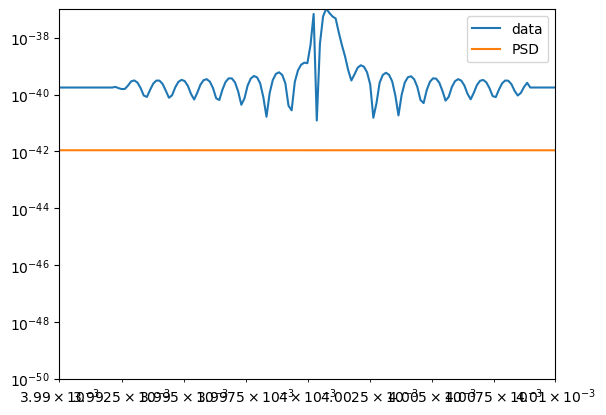

In [5]:
sens_mat = AE1SensitivityMatrix(freqs, model="sangria", stochastic_params=(YRSID_SI,))

data = [np.zeros_like(freqs, dtype=complex), np.zeros_like(freqs, dtype=complex)]
data[0] += AET[0, 0]
data[1] += AET[0, 1]
for i in range(Agb.shape[0]):
    start_ind = start_inds[i]
    A = Agb[i]
    E = Egb[i]

    data[0][start_ind: start_ind + Agb.shape[1]] += A
    data[1][start_ind: start_ind + Agb.shape[1]] += E

plt.loglog(freqs, np.abs(data[0]) ** 2 * 2 * df, label="data")
# plt.loglog(freqs, np.abs(AET[0, 0]) ** 2 * 2 * df, label="MBH")

# for i in range(Agb.shape[0]):
#     start_ind = start_inds[i]
#     A = Agb[i]
#     lab = "GBs" if i == 0 else None
#     plt.loglog(freqs[start_ind: start_ind + Agb.shape[1]], np.abs(A) ** 2 * 2 * df, c="C4", ls='--', label=lab)

plt.loglog(freqs, sens_mat.sens_mat[0], c='C1', label="PSD")
plt.xlim(3.99e-3,4.01e-3)
plt.ylim(1e-50, 1e-37)
plt.legend()

## A Mini Global Fit

Now you will build up a global fit pipeline to fit that data. There are many, many ways to do this. The answer key provided is just one of them. 

Some hints:

* Likelihood: I recommend building an initial Likelihood function that concentrates on gettings the computation right rather than speed. Once, it works, you can run it longer or improve the bottleneck later on. 
* Remember to implement an in-model proposal for the GBs because the stretch proposal will not work.
* I recommend using fixed-dimensional sampling on the MBHB. Use the regular stretch move for this.
* You will have to decide how to deal with the two different groups of GBs. I recommend using two separate models or "branches" in the sampler with different priors. Their priors would differ in their frequency and frequency derivative.
* I recommend using the `eryn.utils.TransformContainer` and the `eryn.utils.PeriodicContainer`.
* Look at Tutorials 4 and 6 for inspiration. 
  

In [6]:
def fill_template(template, A, E, start_inds):
    for i in range(A.shape[0]):
        start_ind = start_inds[i]
        end_ind = start_ind + A.shape[1]
        
        assert end_ind - start_ind == A.shape[1]
        template[0, start_ind:end_ind] += A[i]
        template[1, start_ind:end_ind] += E[i]

def generate_global_template(template, params_all, **waveform_kwargs):
    gb.run_wave(*params_all.T, **waveform_kwargs)  # Te=Tobs, oversample=4)
    fill_template(template, gb.A, gb.E, gb.start_inds)
    
def global_log_likelihood(params_all, analysis, Tobs, dt, waveform_kwargs, transform_containers):
    gb_params_1 = params_all[0]
    gb_params_2 = params_all[1]
    mbh_params = params_all[2]
    
    mbh_params_in = transform_containers["mbh"].both_transforms(mbh_params)

    # print(input_parameters)

    AET = tdi_wave_gen(*mbh_params_in.T, **waveform_kwargs["mbh"])
    template = np.zeros_like(analysis.data_res_arr[:])
    template[0] += AET[0, 0]
    template[1] += AET[0, 1]

    if gb_params_1 is not None:
        gb_params_1_in = transform_containers["gb_1"].both_transforms(gb_params_1)
        generate_global_template(template, gb_params_1_in, **waveform_kwargs["gb_1"])

    if gb_params_2 is not None:
        gb_params_2_in = transform_containers["gb_2"].both_transforms(gb_params_2)
        generate_global_template(template, gb_params_2_in, **waveform_kwargs["gb_2"])
    
    template_in = DataResidualArray(template, f_arr=analysis.data_res_arr.f_arr)
    ll = analysis.template_likelihood(template_in)
    return ll

In [7]:
# imports
from eryn.moves import MHMove

In [8]:
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [9]:
data_arr = DataResidualArray(data, f_arr=freqs)
sens_mat = AE1SensitivityMatrix(freqs)
analysis = AnalysisContainer(data_arr, sens_mat)

In [10]:
class NonScaledDiagonalGaussianMove(MHMove):
    def __init__(self, cov_all, *args, **kwargs):

        for branch_name, cov in cov_all.items():
            assert isinstance(cov, np.ndarray) and cov.ndim == 1

        self.cov = cov_all
        super(NonScaledDiagonalGaussianMove, self).__init__(*args, **kwargs)
        
    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):

        assert branches_inds is not None
        new_points = {}
        for name, cov in self.cov.items():
            assert name in branches_coords
            coords = branches_coords[name]
            inds = branches_inds[name]
            
            ntemps, nwalkers, nleaves_max, ndim = coords.shape

            # generate sigma from normal distribution
            sigma = random.randn(ntemps, nwalkers)

            tmp = np.zeros_like(coords)

            tmp = coords + sigma[:, :, None, None] * cov[None, None, None, :]
            # symmetric
            new_points[name] = np.zeros_like(coords)

            # this is not necessary as the inds will remove there changes in the parent class
            # but I put it here to indicate to think about it
            new_points[name][inds] = tmp[inds]

        # symmetric
        factors = np.zeros((ntemps, nwalkers))
            
        return new_points, factors

In [11]:
from eryn.moves import StretchMove
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer, PeriodicContainer
from eryn.ensemble import EnsembleSampler
nleaves_max = {"gb_1": 10, "gb_2": 10, "mbh": 1}
nleaves_min = {"gb_1": 0, "gb_2": 0, "mbh": 1}
ndims = {"gb_1": 8, "gb_2": 8, "mbh": 11}

nwalkers = 14
ntemps = 12

diag_cov = np.array([1e-24, 1e-10, 1e-19, 0.01, 0.01, 0.01, 0.01, 0.01])
cov_1    = {"gb_1": diag_cov}
gb_move_1 = NonScaledDiagonalGaussianMove(cov_1, gibbs_sampling_setup=["gb_1"])

cov_2    = {"gb_2": diag_cov}
gb_move_2 = NonScaledDiagonalGaussianMove(cov_2, gibbs_sampling_setup=["gb_2"])

mbh_move = StretchMove(gibbs_sampling_setup=["mbh"], live_dangerously=True)

moves = [gb_move_1, gb_move_2, mbh_move]

priors = {
    "gb_1": ProbDistContainer({
        0: uniform_dist(1e-23, 2e-22),
        1: uniform_dist(0.00400, 0.00401),
        2: uniform_dist(0.01e-17, 2e-17),
        3: uniform_dist(0.0, 2 * np.pi),
        4: uniform_dist(-1.0, 1.0),
        5: uniform_dist(0.0, np.pi),
        6: uniform_dist(0.0, 2 * np.pi),
        7: uniform_dist(-1.0, 1.0),
    }),
    "gb_2": ProbDistContainer({
        0: uniform_dist(1e-23, 2e-22),
        1: uniform_dist(0.00500, 0.00501),
        2: uniform_dist(1e-17, 1e-18),
        3: uniform_dist(0.0, 2 * np.pi),
        4: uniform_dist(-1.0, 1.0),
        5: uniform_dist(0.0, np.pi),
        6: uniform_dist(0.0, 2 * np.pi),
        7: uniform_dist(-1.0, 1.0),
    }),
    "mbh": ProbDistContainer({
        0: uniform_dist(np.log(1e5), np.log(4e6)),
        1: uniform_dist(0.05, 0.99999),
        2: uniform_dist(-0.99999, 0.99999),
        3: uniform_dist(-0.99999, 0.99999),
        4: uniform_dist(0.0, 1000.0),
        5: uniform_dist(0.0, 2 * np.pi),
        6: uniform_dist(-1.0, 1.0),
        7: uniform_dist(0.0, 2 * np.pi),
        8: uniform_dist(-1.0, 1.0),
        9: uniform_dist(0.0, np.pi),
        10: uniform_dist(t_ref - 10000.0, t_ref + 10000.0),
    }),
}

waveform_kwargs = {
    "gb_1": dict(N=128, T=Tobs, dt=dt),
    "gb_2": dict(N=128, T=Tobs, dt=dt),
    "mbh": dict(
        length=1024, 
        combine=False, 
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    )
}

gb_param_trans = {
    5: np.arccos,  # cos(inc)
    8: np.arcsin  # sin(beta) -> # index is after filling, 
    # so on the waveform generation basis (D=9) , not sampling basis (D=8)
}

gb_fill_dict = {
    "ndim_full": 9,
    "fill_inds": np.array([3]),  # fddot
    "fill_values": np.array([0.0])
}

gb_transform_fn = TransformContainer(parameter_transforms=gb_param_trans, fill_dict=gb_fill_dict)

mbh_param_trans = {
    0: np.exp,
    4: lambda x: x * PC_SI * 1e9,
    7: np.arccos,  # after filling so 7 not 6
    9: np.arcsin,   # after filling so 9 not 8
    (0, 1): lambda mT, q: (mT / (1 + q), mT * q / (1 + q))  # transform mT, q -> m1, m2
}

mbh_fill_dict = {
    "ndim_full": 12,
    "fill_inds": np.array([6]),  # f_ref
    "fill_values": np.array([0.0])
}


mbh_transform_fn = TransformContainer(parameter_transforms=mbh_param_trans, fill_dict=mbh_fill_dict)

transform_containers = dict(
    gb_1=gb_transform_fn,
    gb_2=gb_transform_fn,
    mbh=mbh_transform_fn,
)

# on the sampling basis
periodic = {
    "gb_1": {3: 2 * np.pi, 5: np.pi, 6: 2 * np.pi},
    "gb_2": {3: 2 * np.pi, 5: np.pi, 6: 2 * np.pi},
    "mbh": {5: 2 * np.pi, 7: 2 * np.pi, 9: np.pi},
}
    
sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    global_log_likelihood,
    priors,
    branch_names=["gb_1", "gb_2", "mbh"],
    nbranches=3,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    args=(analysis, Tobs, dt, waveform_kwargs, transform_containers),
    rj_moves=True,  # this will draw from the prior for the GBs
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/eryn/ensemble.py:442: UserWarning: If using revisible jump, using the Stretch Move for in-model proposals is not advised. It will run and work, but it will not be using the correct complientary group of parameters meaning it will most likely be very inefficient.
  warnings.warn(


In [12]:
from eryn.state import State

# draw from prior and turn all off but 1
start_points = {key: priors[key].rvs(size=(ntemps, nwalkers, nleaves_max[key])) for key in ["gb_1", "gb_2"]}

injection_params_mbh = np.array([
    np.log(m1 + m2),
    m2 / m1, 
    chi1, 
    chi2, 
    dist / (1e9 * PC_SI), 
    phi_ref % (2 * np.pi), 
    np.cos(inc), 
    lam % (2 * np.pi), 
    np.sin(beta), 
    psi % np.pi, 
    t_ref
])
start_params_mbh = injection_params_mbh[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_mbh.shape[0]))
start_points["mbh"] = start_params_mbh

start_inds = {"mbh": np.ones((ntemps, nwalkers, nleaves_max["mbh"]), dtype=bool)}

start_inds["gb_1"] = np.zeros((ntemps, nwalkers, nleaves_max["gb_1"]), dtype=bool)
start_inds["gb_1"][:, :, 0] = True

start_inds["gb_2"] = np.zeros((ntemps, nwalkers, nleaves_max["gb_2"]), dtype=bool)
start_inds["gb_2"][:, :, 0] = True

start_state = State(start_points, inds=start_inds)


In [13]:
lp = sampler_rj.compute_log_prior(start_state.branches_coords, inds=start_state.branches_inds)
start_state.log_prior = lp

In [14]:
lp

array([[162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504],
       [162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504],
       [162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504],
       [162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504, 162.68913504],
       [162.68913504, 162.68913504, 162.68913504, 162.68913504,
        162.68913504

In [15]:
ll = sampler_rj.compute_log_like(start_state.branches_coords, inds=start_state.branches_inds, logp=lp)
start_state.log_like = ll[0]


In [16]:
ll

(array([[-450924.54516747, -451840.54915735, -454115.46043249,
         -450968.75057651, -450781.61640798, -450325.57671324,
         -466351.63584628, -450487.45305245, -450325.88667971,
         -450033.93849954, -452365.31031163, -451389.10291687,
         -451648.4689812 , -451308.31887738],
        [-453380.33830538, -457682.63146103, -450976.97281365,
         -458336.84987208, -451556.09488283, -450866.1125224 ,
         -451830.80546086, -451735.64025114, -450431.24767762,
         -451916.09159951, -450157.35007657, -450933.30100957,
         -424093.4692797 , -450518.43666669],
        [-450319.19849494, -449947.86573739, -450803.52363048,
         -454040.90378113, -450650.64809049, -454113.67024338,
         -450096.96499899, -450433.5509181 , -451181.35317712,
         -450684.85806871, -451614.75260533, -451158.47923109,
         -456727.56682768, -453963.51570638],
        [-450120.55564924, -451650.97215831, -454180.4183918 ,
         -450664.42298262, -449764.56590375

In [17]:
sampler_rj.run_mcmc(start_state, 2, progress=True)

  0%|                                                     | 0/2 [00:00<?, ?it/s]/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/eryn/moves/move.py:415: RuntimeWarning: invalid value encountered in divide
  return self.accepted / self.num_proposals
100%|█████████████████████████████████████████████| 2/2 [03:10<00:00, 95.16s/it]
